In [15]:
import numpy as np
import pandas as pd
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt


In [2]:
data_dir = "../raw_data/images_png/"


In [3]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(64, 376),
  batch_size=32,
  color_mode = "grayscale")


Found 38044 files belonging to 34 classes.
Using 30436 files for training.


In [4]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(64, 376),
  batch_size=32,
  color_mode = "grayscale")


Found 38044 files belonging to 34 classes.
Using 7608 files for validation.


In [5]:
class_names = train_ds.class_names
print(class_names)


['banswa', 'barswa', 'calqua', 'cangoo', 'caster1', 'comloo', 'comrav', 'comred', 'comter', 'eargre', 'eucdov', 'eursta', 'gadwal', 'gnwtea', 'goleag', 'greegr', 'hergul', 'horlar', 'houspa', 'mallar3', 'merlin', 'norsho', 'osprey', 'pecsan', 'perfal', 'redcro', 'ribgul', 'rinduc', 'rocpig', 'rudduc', 'sheowl', 'silence', 'snobun', 'tunswa']


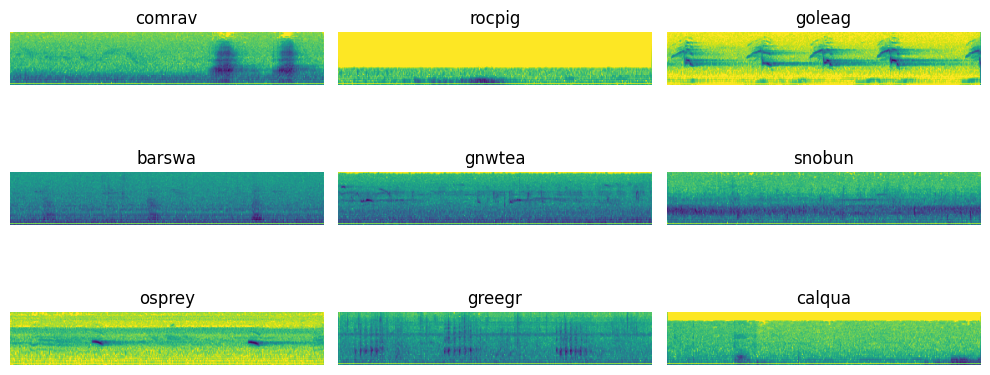

In [43]:
plt.figure(figsize=(10, 6))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")
    plt.tight_layout()


In [7]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(64, 376, 1)),
  layers.Conv2D(16, 1, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 1, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 1, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [8]:
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 64, 376, 1)        0         
                                                                 
 conv2d (Conv2D)             (None, 64, 376, 16)       32        
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 188, 16)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 188, 32)       544       
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 16, 94, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 94, 64)        2

In [9]:
epochs=1
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)


952/952 [==============================] - 48s 50ms/step - loss: 2.8543 - accuracy: 0.2307 - val_loss: 2.5201 - val_accuracy: 0.3130


In [10]:
epochs=30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)


Epoch 1/30
952/952 [==============================] - 46s 48ms/step - loss: 2.3702 - accuracy: 0.3469 - val_loss: 2.3081 - val_accuracy: 0.3667
Epoch 2/30
952/952 [==============================] - 46s 49ms/step - loss: 2.1958 - accuracy: 0.3962 - val_loss: 2.2002 - val_accuracy: 0.3994
Epoch 3/30
952/952 [==============================] - 47s 49ms/step - loss: 2.0815 - accuracy: 0.4273 - val_loss: 2.1306 - val_accuracy: 0.4232
Epoch 4/30
952/952 [==============================] - 45s 48ms/step - loss: 1.9950 - accuracy: 0.4521 - val_loss: 2.0697 - val_accuracy: 0.4368
Epoch 5/30
952/952 [==============================] - 44s 47ms/step - loss: 1.9303 - accuracy: 0.4706 - val_loss: 2.0131 - val_accuracy: 0.4564
Epoch 6/30
952/952 [==============================] - 44s 47ms/step - loss: 1.8720 - accuracy: 0.4849 - val_loss: 1.9883 - val_accuracy: 0.4645
Epoch 7/30
952/952 [==============================] - 44s 47ms/step - loss: 1.8284 - accuracy: 0.4999 - val_loss: 1.9748 - val_accuracy:

In [12]:
""""""
model_1 = Sequential([
  layers.Rescaling(1./255, input_shape=(64, 376, 1)),

  layers.Conv2D(64, (2,2), padding='same', activation='relu'),
  layers.MaxPooling2D(pool_size=(2, 2)),
  layers.Conv2D(64, (2,3), padding='same', activation='relu'),
  layers.MaxPooling2D(pool_size=(2, 2)),
  layers.Conv2D(64, (3,2), padding='same', activation='relu'),
  layers.MaxPooling2D(pool_size=(2, 2)),
  layers.Conv2D(32, (3,3), padding='same', activation='relu'),
  layers.MaxPooling2D(pool_size=(2, 2)),
  layers.Conv2D(32, (5,5), padding='same', activation='relu'),
  layers.MaxPooling2D(pool_size=(2, 2)),
  layers.Dropout(0.24),
  layers.Flatten(),
  layers.Dense(1568, activation='relu'),
  layers.Dense(500, activation='relu'),
  layers.Dense(num_classes)
])

model_1.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [13]:
model_1.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 64, 376, 1)        0         
                                                                 
 conv2d_8 (Conv2D)           (None, 64, 376, 64)       320       
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 32, 188, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_9 (Conv2D)           (None, 32, 188, 64)       24640     
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 16, 94, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 16, 94, 64)       

In [16]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

# Clear any logs from previous runs
!rm -rf ./logs/

# We will store the logs in a folder (one folder per fit)
import datetime
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")


In [14]:
es = EarlyStopping(monitor='val_loss',
                   mode='min',
                   verbose=1,
                   patience=5)


epochs=30
history = model_1.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[es]
)


Epoch 1/30
952/952 [==============================] - 1655s 2s/step - loss: 2.6080 - accuracy: 0.2744 - val_loss: 1.9720 - val_accuracy: 0.4590
Epoch 2/30
952/952 [==============================] - 556s 585ms/step - loss: 1.7615 - accuracy: 0.5039 - val_loss: 1.6015 - val_accuracy: 0.5532
Epoch 3/30
952/952 [==============================] - 375s 394ms/step - loss: 1.4215 - accuracy: 0.5997 - val_loss: 1.3121 - val_accuracy: 0.6359
Epoch 4/30
952/952 [==============================] - 474s 498ms/step - loss: 1.1905 - accuracy: 0.6595 - val_loss: 1.2420 - val_accuracy: 0.6613
Epoch 5/30
952/952 [==============================] - 6957s 7s/step - loss: 0.9997 - accuracy: 0.7104 - val_loss: 1.1492 - val_accuracy: 0.6872
Epoch 6/30
952/952 [==============================] - 2584s 3s/step - loss: 0.8501 - accuracy: 0.7520 - val_loss: 1.0626 - val_accuracy: 0.7178
Epoch 7/30
952/952 [==============================] - 289s 303ms/step - loss: 0.7207 - accuracy: 0.7833 - val_loss: 1.0620 - val_a

In [17]:
%tensorboard --logdir logs/fit

tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)


In [38]:
def plot_history(history, metric_label, title='', axs=None, exp_name=""):
    if axs is not None:
        ax1, ax2 = axs
    else:
        fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

    if len(exp_name) > 0 and exp_name[0] != '_':
        exp_name = '_' + exp_name

    ax1.plot(history.history['loss'], label = 'train' + exp_name)
    ax1.plot(history.history['val_loss'], label = 'val' + exp_name)
    ax1.set_ylim(min(history.history['loss']) * 0.8,
                 max(history.history['loss']) * 1.1,)
    ax1.set_title('loss')
    ax1.legend()
    ax1.set_xlabel('epochs')
    ax1.spines.right.set_visible(False)
    ax1.spines.top.set_visible(False)

    ax2.plot(history.history[metric_label], label='train ' + metric_label  + exp_name)
    ax2.plot(history.history['val_'+metric_label], label='val ' + metric_label  + exp_name)
    ax2.set_ylim(min(history.history[metric_label]) * 0.8,
                 max(history.history[metric_label]) * 1.1)
    ax2.set_title(metric_label.capitalize())
    ax2.legend()
    ax2.set_xlabel('epochs')
    ax2.spines.right.set_visible(False)
    ax2.spines.top.set_visible(False)
    return (ax1, ax2)


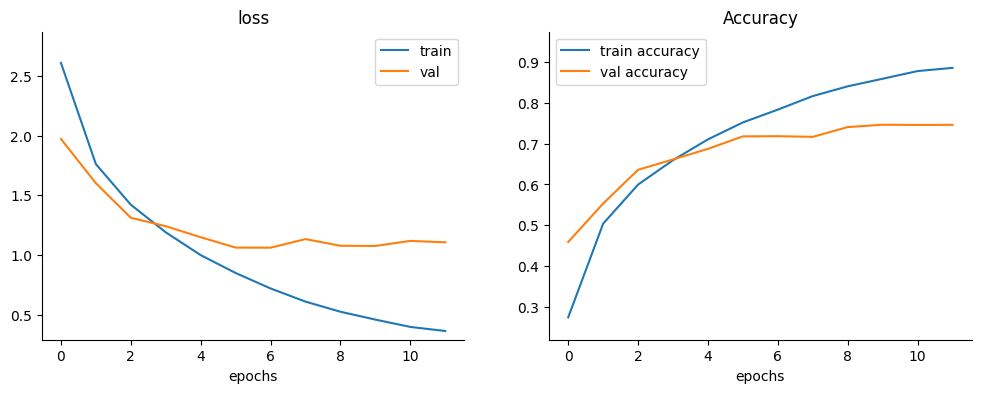

In [40]:
plot_history(history, 'accuracy', title='', axs=None, exp_name="")
plt.show()
